In [1]:
%matplotlib inline

In [38]:
import sqlite3
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import sys
sys.path.insert(0, os.path.abspath('..'))
from milleniumcohort import create_config
config = create_config('../config.yml')

In [6]:
conn = sqlite3.connect(os.path.join(config.model_path, 'milleniumcohort.db'))

In [7]:
state_times_long = pd.read_sql('Select filename, state, count(*) from data_with_states group by filename, state', conn)
state_times = state_times_long.pivot('filename', 'state')

In [40]:
cutoff_times_long = pd.read_sql('Select filename, heuristic, count(*) from data_with_states group by filename, heuristic', conn)
cutoff_times = cutoff_times_long.pivot('filename', 'heuristic')

In [13]:
total_5sec = state_times.sum(axis=1)
state_times_norm = state_times.divide(total_5sec, axis='index')

# Only take min 20 hours
state_times_norm = state_times_norm[total_5sec>20*60*12]
state_times_norm = state_times_norm.fillna(0)

In [41]:
total_5sec = cutoff_times.sum(axis=1)
cutoff_times_norm = cutoff_times.divide(total_5sec, axis='index')

# Only take min 20 hours
cutoff_times_norm = cutoff_times_norm[total_5sec>20*60*12]
cutoff_times_norm = cutoff_times_norm.fillna(0)

In [23]:
from sklearn.decomposition import PCA

(1190, 10)


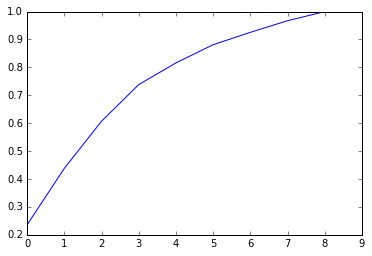

In [43]:
X_states = state_times_norm.as_matrix()
print(X_states.shape)
pca = PCA(n_components=X_states.shape[1])
pca.fit(X_states)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

(1190, 7)


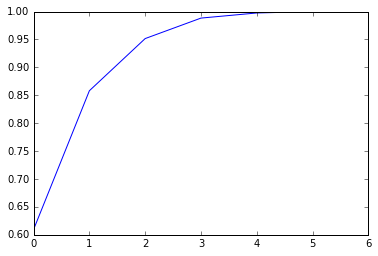

In [45]:
X_cutoff = cutoff_times_norm.as_matrix()
print(X_cutoff.shape)
pca_cutoff = PCA(n_components=X_cutoff.shape[1])
pca_cutoff.fit(X_cutoff)
plt.plot(np.cumsum(pca_cutoff.explained_variance_ratio_))

In [64]:
cmap = plt.cm.get_cmap('coolwarm')

In [69]:
cmap([4,6,3])

array([[ 0.24809122,  0.32601302,  0.77766865,  1.        ],
       [ 0.25723398,  0.33966055,  0.7896614 ,  1.        ],
       [ 0.24351984,  0.31918926,  0.77167228,  1.        ]])

In [ ]:
correlations_states = pd.DataFrame(np.corrcoef(X_states.transpose()))
correlations_states.style.applymap(lambda v:  ['background-color: %s' % str(color) for color in cmap(v/256.0)])

In [52]:
correlations_cutoff = pd.DataFrame(np.corrcoef(X_cutoff.transpose()))
correlations_cutoff.style.background_gradient(cmap='coolwarm',axis=1)

,0,1,2,3,4,5,6
0,1,-0.301452,-0.472309,-0.407263,-0.166039,-0.349531,-0.120458
1,-0.301452,1,0.603222,0.473667,-0.165442,0.208035,-0.697425
2,-0.472309,0.603222,1,0.835129,-0.0187434,0.499556,-0.633488
3,-0.407263,0.473667,0.835129,1,0.0680107,0.67624,-0.631378
4,-0.166039,-0.165442,-0.0187434,0.0680107,1,0.267769,-0.19922
5,-0.349531,0.208035,0.499556,0.67624,0.267769,1,-0.460695
6,-0.120458,-0.697425,-0.633488,-0.631378,-0.19922,-0.460695,1
